In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
#from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-05-29 17:19:08.801607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 17:19:08.956560: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-29 17:19:09.459302: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-29 17:19:09.459346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,4,644.6140,364.11
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
83
77


Text(0, 0.5, 'count')

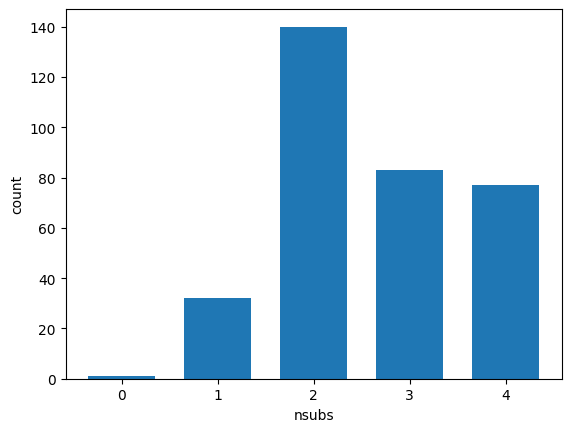

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)
plt.xlabel('nsubs')
plt.ylabel('count')

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,333.0,0.345345,0.936678,0.0000,0.0000,0.0000,0.0000,4.0000
Pos2,333.0,0.444444,1.081362,0.0000,0.0000,0.0000,0.0000,4.0000
Pos3,333.0,0.369369,0.978023,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,333.0,0.426426,1.040516,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,333.0,0.429429,1.037826,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,333.0,0.363363,0.961664,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,333.0,0.366366,0.955806,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,333.0,0.450450,1.084436,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,333.0,0.483483,1.104699,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,333.0,0.435435,1.075272,0.0000,0.0000,0.0000,0.0000,4.0000


/tmp/ipykernel_19150/2418938743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


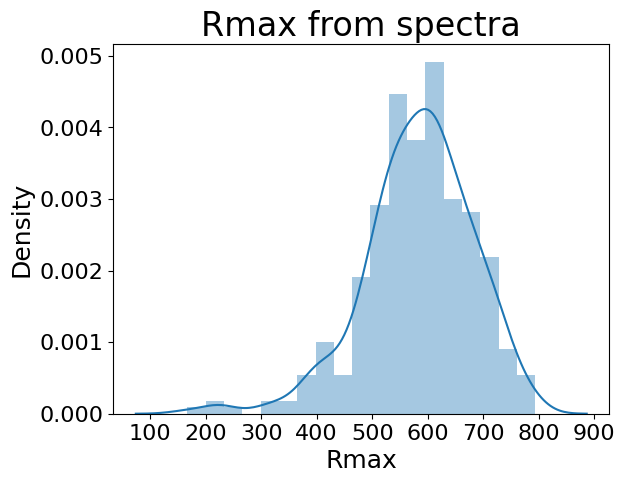

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
#sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('Rmax from spectra',fontsize=24)
plt.xlabel('Rmax',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Text(0, 0.5, 'Rmax')

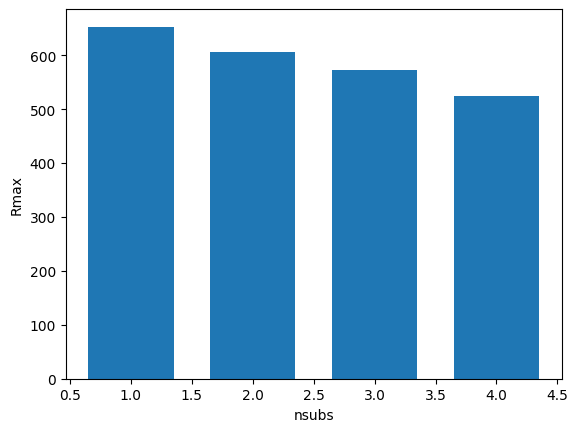

In [7]:
# Rmax as a function of nsubs
Rmax = []
Rmax[:] = dataframe['target']

nsubs1 = [i for i in range(len(nsubs)) if nsubs[i]==1]
nsubs2 = [i for i in range(len(nsubs)) if nsubs[i]==2]
nsubs3 = [i for i in range(len(nsubs)) if nsubs[i]==3]
nsubs4 = [i for i in range(len(nsubs)) if nsubs[i]==4]

Rmax1 = [Rmax[i] for i in nsubs1]
Rmax2 = [Rmax[i] for i in nsubs2]
Rmax3 = [Rmax[i] for i in nsubs3]
Rmax4 = [Rmax[i] for i in nsubs4]

Rmax1_mean = np.mean(Rmax1)
Rmax2_mean = np.mean(Rmax2)
Rmax3_mean = np.mean(Rmax3)
Rmax4_mean = np.mean(Rmax4)

Rmax_mean = [Rmax1_mean, Rmax2_mean, Rmax3_mean, Rmax4_mean]

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([1,2,3,4],Rmax_mean, width=0.7)
plt.xlabel('nsubs')
plt.ylabel('Rmax')


In [8]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min         25%        50%  \
Pos1    324.0    0.333333   0.931060    0.0000    0.000000    0.00000   
Pos2    324.0    0.416667   1.039096    0.0000    0.000000    0.00000   
Pos3    324.0    0.351852   0.953872    0.0000    0.000000    0.00000   
Pos4    324.0    0.404321   1.004686    0.0000    0.000000    0.00000   
Pos5    324.0    0.429012   1.031046    0.0000    0.000000    0.00000   
Pos6    324.0    0.361111   0.952022    0.0000    0.000000    0.00000   
Pos7    324.0    0.376543   0.967045    0.0000    0.000000    0.00000   
Pos8    324.0    0.453704   1.087938    0.0000    0.000000    0.00000   
Pos9    324.0    0.490741   1.114181    0.0000    0.000000    0.00000   
Pos10   324.0    0.435185   1.069763    0.0000    0.000000    0.00000   
Pos11   324.0    0.364198   0.968585    0.0000    0.000000    0.00000   
Pos12   324.0    0.398148   1.031454    0.0000    0.000000    0.00000   
Pos13   324.0    0.256173   0.821042    0.0000    0

In [9]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,324.0,3.333333e-01,0.931060,0.000000,0.000000,0.00000,0.00000,4.000000
Pos2,324.0,4.166667e-01,1.039096,0.000000,0.000000,0.00000,0.00000,4.000000
Pos3,324.0,3.518519e-01,0.953872,0.000000,0.000000,0.00000,0.00000,4.000000
Pos4,324.0,4.043210e-01,1.004686,0.000000,0.000000,0.00000,0.00000,4.000000
Pos5,324.0,4.290123e-01,1.031046,0.000000,0.000000,0.00000,0.00000,4.000000
Pos6,324.0,3.611111e-01,0.952022,0.000000,0.000000,0.00000,0.00000,4.000000
Pos7,324.0,3.765432e-01,0.967045,0.000000,0.000000,0.00000,0.00000,4.000000
Pos8,324.0,4.537037e-01,1.087938,0.000000,0.000000,0.00000,0.00000,4.000000
Pos9,324.0,4.907407e-01,1.114181,0.000000,0.000000,0.00000,0.00000,4.000000
Pos10,324.0,4.351852e-01,1.069763,0.000000,0.000000,0.00000,0.00000,4.000000


In [10]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
n_pos = 16         # 6-helicenes have 16 possible positions to be occupied
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(324, 80)
(324,)
(324, 81)


In [27]:
# number of adjacent pairs
n_dim_2body = n_atom_types * n_atom_types

# Define one-hot encode vectors for atoms pairs

n_features_2body = (n_pos-1) * n_dim_2body
x_data_1body = np.zeros((n_data,n_features))
x_data_2body = np.zeros((n_data,n_features_2body))
x_data_both = np.zeros((n_data,n_features+n_features_2body))

# 1-body inputs
x_data_1body = x_data.copy()
x_data_both[:,0:n_features] = x_data_1body[:,0:n_features]

# 2-body inputs
for i in range(n_data):

    #train_inputs = np.split(x_train,n_pos,axis=1)
    #x_1b = np.split(x_data_1body,n_pos,axis=1)
    x_1b = np.split(x_data_1body[i,:],n_pos)
    #print(x_1b)
    #print(x_1b[10])

    x_2b = []

    # Positions 1-8
    # Left side of the molecule
    for j in range(8):
        #print(j)
        xj = x_1b[j]
        xj_next = x_1b[j+1]
        xj_2b = np.tensordot(xj,xj_next,axes=0)
        xj_2b = xj_2b.flatten()
        #print(str(xj)+'  '+str(xj_next)+'  '+str(xj_2b))        
        x_2b.append(xj_2b)

    # Positions 9-15 (position 16 is not included because it has no adjacent position to the right)
    # Right side of the molecule
    for j in reversed(range(8,15)):
        #print(j)
        xj = x_1b[j]
        xj_next = x_1b[j-1]
        xj_2b = np.tensordot(xj,xj_next,axes=0)
        xj_2b = xj_2b.flatten()
        #print(str(xj)+'  '+str(xj_next)+'  '+str(xj_2b))
        x_2b.append(xj_2b)

    x_2b = np.array(x_2b)
    #print(x_2b)
    x_2b = x_2b.flatten()
    #print(x_2b)

    x_data_2body[i,:] = x_2b

    x_data_both[i,0:n_features] = x_data_1body[i,:]
    x_data_both[i,n_features:] = x_data_2body[i,:]

#print(x_2d.shape)
#print(x_data_1body[0,:])
#print(x_data_2body[0,:])
#print(x_data_both[0,:])

In [28]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#x_data = data[:,0:n_features]
#y_data = data[:,n_features]
#data = shuffle(data, random_state=39)
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_data_both, y_data, test_size=0.2, random_state=42)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

259 training examples
65 test and validation examples
(259, 455)
(259,)


In [29]:
# 2-body model with two inputs

# -------------------------------------------------------------------
# INPUTS
# -------------------------------------------------------------------
print('INPUTS')

#inputs_1b = tf.keras.Input(shape=(n_features,),name='Molecule')
#inputs_2b = tf.keras.Input(shape=(n_features_2body,),name='Pairs')
inputs_1b = tf.keras.Input(shape=(None,n_features),name='Molecule')
inputs_2b = tf.keras.Input(shape=(None,n_features_2body),name='Pairs')
print(inputs_1b)
print(inputs_2b)

# -------------------------------------------------------------------
# 1-body term
# -------------------------------------------------------------------
print()
print('1-BODY')


# Split the input vector into differents positions with cropping
inputs_1b_aux = tf.keras.layers.Reshape((n_features,1), input_shape=(n_features,),name='Molecule_aux')(inputs_1b)

single_position = []
for i in range(n_pos):
    init = i * n_atom_types
    end = init + n_atom_types
    left_crop = init
    right_crop = n_features - end
    pos_i = tf.keras.layers.Cropping1D(cropping=(left_crop,right_crop),name='Pos_'+str(i))(inputs_1b_aux)
    #pos_i = tf.keras.layers.Cropping1D(cropping=(0,40))(inputs_1b)
    print(pos_i)
    single_position.append(pos_i)

# Define architecture of 1-body models
def model_1body():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal',name='1B_'+str(i))(inputs)
    return tf.keras.Model(inputs,outputs, name='1B_'+str(i))

# save 8 models into a list 
models_1b = []
for i in range(int(n_pos/2)):
    model_i = model_1body()
    models_1b.append(model_i)

# Apply each model to each position
outputs_1b = []
# Positions 1-8
for i in range(int(n_pos/2)):
    output_i = models_1b[i]( single_position[i] )
    outputs_1b.append( output_i )
# Positions 9-16
for i in range(int(n_pos/2),n_pos):
    output_i = models_1b[n_pos-1-i]( single_position[i] )
    outputs_1b.append( output_i )    
print(len(outputs_1b))

# -------------------------------------------------------------------
# 2-body term
# -------------------------------------------------------------------
print()
print('2-BODY')

# Split the input vector into differents pairs with cropping
inputs_2b_aux = tf.keras.layers.Reshape((n_features_2body,1), input_shape=(n_features,),name='Pairs_aux')(inputs_2b)

single_pair = []
for i in range(n_pos-1):
    init = i * n_dim_2body
    end = init + n_dim_2body
    left_crop = init
    right_crop = n_features_2body - end
    pair_i = tf.keras.layers.Cropping1D(cropping=(left_crop,right_crop),name='Pair_'+str(i))(inputs_2b_aux)
    #pos_i = tf.keras.layers.Cropping1D(cropping=(0,40))(inputs_1b)
    print(pair_i)
    single_pair.append(pair_i)

# Define architecture of 2-body models
def model_2body():
    inputs = tf.keras.Input( shape=(n_dim_2body,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal',name='2B_'+str(i))(inputs)
    return tf.keras.Model(inputs,outputs, name='2B_'+str(i))

# save 8 models into a list 
models_2b = []
for i in range(int(n_pos/2)):
    model_i = model_2body()
    models_2b.append(model_i)
print()
print(models_2b)

# Apply each model to each position
outputs_2b = []
# Positions 1-8
for i in range(int(n_pos/2)):
    output_i = models_2b[i]( single_pair[i] )
    outputs_2b.append( output_i )
# Positions 9-16
for i in range(int(n_pos/2),n_pos-1):
    output_i = models_2b[n_pos-1-i]( single_pair[i] )
    outputs_2b.append( output_i )    
print(len(outputs_2b))

# -------------------------------------------------------------------
# Global model
# -------------------------------------------------------------------

sum1 = tf.keras.layers.Add(name='SUM_1B')(outputs_1b)
sum2 = tf.keras.layers.Add(name='SUM_2B')(outputs_2b)
global_output = tf.keras.layers.Add(name='SUM')([sum1,sum2])
print(global_output)

model = tf.keras.Model(inputs=[inputs_1b,inputs_2b],outputs=global_output)
model.summary()

tf.keras.utils.plot_model(model, "2body_invariant_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')

INPUTS
KerasTensor(type_spec=TensorSpec(shape=(None, None, 80), dtype=tf.float32, name='Molecule'), name='Molecule', description="created by layer 'Molecule'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, 375), dtype=tf.float32, name='Pairs'), name='Pairs', description="created by layer 'Pairs'")

1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name

In [ ]:
""" # 2-body model with multiple inputs

# save into a list 1-body inputs for different positions
inputs1 = []
inputs = []
for i in range(n_pos):
    input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_'+str(i+1) )
    inputs1.append( input_i ) 
    inputs.append( input_i ) 
    #input_i = tf.keras.Input(shape=(n_atom_types,name="Pos_i"))
    #input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_i' )
print(inputs1)

# save into a list 2-body inputs from different pairs
inputs2 = []
for i in range(n_pos-1):
    input_i = tf.keras.Input( shape=(n_dim_2body,), name='Pair_'+str(i+1) )
    inputs2.append( input_i ) 
    inputs.append( input_i ) 
    #input_i = tf.keras.Input(shape=(n_atom_types,name="Pos_i"))
    #input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_i' )
print(inputs2)
print(inputs)

# First, define a 1-body model for a single position
def single_model():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False)(inputs)
    return tf.keras.Model(inputs,outputs)

# save into a list 8 models
linear_models = []
for i in range(int(n_pos/2)):
    model_i = single_model()
    linear_models.append(model_i)

# Second, define a 2-body models for adjacent pairs
def model_2body():
    inputs = tf.keras.Input( shape=(n_dim_2body,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False)(inputs)
    return tf.keras.Model(inputs,outputs)

# save into a list 8 2-body models
models_2body = []
for i in range(int(n_pos/2)):
    model_i = model_2body()
    models_2body.append(model_i)

linear_outputs = []
# save into a list linear outputs for positions 1-8
for i in range(int(n_pos/2)):
    output_i = linear_models[i]( inputs1[i] )
    linear_outputs.append( output_i )

# save into a list linear outputs for positions 9-16
for i in range(int(n_pos/2),n_pos):
    output_i = linear_models[n_pos-1-i]( inputs1[i] )
    linear_outputs.append( output_i )  

outputs_2body = []
# save into a list 2-body outputs for positions 1-8
for i in range(int(n_pos/2)):
    output_i = models_2body[i]( inputs2[i] )
    outputs_2body.append( output_i )

# save into a list 2-body outputs for positions 9-15
for i in range(int(n_pos/2),n_pos-1):
    output_i = models_2body[n_pos-1-i]( inputs2[i] )
    outputs_2body.append( output_i )   


""" linear_outputs = []
#linear_models = []
# save into a list linear outputs and models for positions 1-8
for i in range(n_pos/2):
    #output_i = tf.keras.layers.Dense(1,name='W_'+str(i+1))(inputs[i])
    #linear_outputs.append( output_i )
    #model_i = tf.keras.Model(inputs=inputs[i],outputs=output_i)
    #linear_models.append( model_i )
    output_i = linear_models[i]( inputs[i] )

# save into a list linear outputs and models for positions 9-16
for i in range(n_pos/2,n_pos):
    #output_i = tf.keras.layers.Dense(1,name='W_'+str(i+1))(inputs[i])
    output_i = linear_outputs[n_pos-1-i] # model for Pos 16 (index 15) is equal to model por Pos 1 (index 0)
    linear_outputs.append( output_i )
    #model_i = tf.keras.Model(inputs=inputs[i],outputs=output_i)
    model_i = linear_models[]
    linear_models.append( model_i )     """

print(linear_outputs)

#global_output = tf.keras.layers.Add(name='SUM')(linear_outputs)
#print(global_output)

output_1b = tf.keras.layers.Add(name='SUM1')(linear_outputs)
output_2b = tf.keras.layers.Add(name='SUM2')(outputs_2body)
global_output = tf.keras.layers.Add(name='SUM')([ output_1b, output_2b ])

#model = tf.keras.Model(inputs=[inputs1,inputs2],outputs=global_output)
model = tf.keras.Model(inputs=[inputs],outputs=global_output)
model.summary()
tf.keras.utils.plot_model(model, "2body_invariant_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error') """

In [ ]:
""" # Train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-8)

epochs = 200
batch_size = 4

# split inputs for 1-body and 2-body terms

x_train_1b = x_train[:,0:n_features]
x_train_2b = x_train[:,n_features:]

train_inputs_1b = np.split(x_train_1b,n_pos,axis=1)
train_inputs_2b = np.split(x_train_2b,n_pos-1,axis=1)
print(len(train_inputs_1b))
print(len(train_inputs_2b))

#train_inputs_1b = np.array(train_inputs_1b)
#print(train_inputs_1b.shape)
#train_inputs_2b = np.array(train_inputs_2b)
#print(train_inputs_2b.shape)

""" train_inputs_both = [[[]]]

for i in range[x_train.shape[0]]:
    jpos = 0
    for j in range(n_pos):
        for k in range(5)
            train_inputs_both[jpos][i][k] = x_train[]

        jpos = jpos + 1 """

train_inputs_both = [ train_inputs_1b, train_inputs_2b ]
train_inputs_both = np.array(train_inputs_both)
print(train_inputs_both.shape)



#history = model.fit(x=[train_inputs_1b,train_inputs_2b], y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
#history = model.fit(x=train_inputs], y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2) """

In [30]:
# Train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-8)

epochs = 200
batch_size = 4

print(x_train.shape)
x_train_1b = x_train[:,0:n_features]
x_train_2b = x_train[:,n_features:]
print(x_train_1b.shape)
print(x_train_2b.shape)
print(y_train.shape)

#history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
#history = model.fit(x=train_inputs, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
history = model.fit(x=[x_train_1b,x_train_2b], y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
#history = model.fit(x=[x_train[:,0:n_features],x_train[:,n_features:]], y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
#history = model.fit(x={"Molecule": x_train_1b, "Pairs": x_train_2b}, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)




(259, 455)
(259, 80)
(259, 375)
(259,)
Epoch 1/200


59/59 - 1s - loss: 0.7833 - val_loss: 0.5830 - lr: 0.0100 - 1s/epoch - 24ms/step
Epoch 2/200
59/59 - 0s - loss: 0.5245 - val_loss: 0.4584 - lr: 0.0100 - 73ms/epoch - 1ms/step
Epoch 3/200
59/59 - 0s - loss: 0.4066 - val_loss: 0.4841 - lr: 0.0100 - 71ms/epoch - 1ms/step
Epoch 4/200
59/59 - 0s - loss: 0.3644 - val_loss: 0.3452 - lr: 0.0100 - 71ms/epoch - 1ms/step
Epoch 5/200
59/59 - 0s - loss: 0.3357 - val_loss: 0.2601 - lr: 0.0100 - 78ms/epoch - 1ms/step
Epoch 6/200
59/59 - 0s - loss: 0.3015 - val_loss: 0.2715 - lr: 0.0100 - 74ms/epoch - 1ms/step
Epoch 7/200
59/59 - 0s - loss: 0.2924 - val_loss: 0.4577 - lr: 0.0100 - 80ms/epoch - 1ms/step
Epoch 8/200
59/59 - 0s - loss: 0.2874 - val_loss: 0.3186 - lr: 0.0100 - 91ms/epoch - 2ms/step
Epoch 9/200
59/59 - 0s - loss: 0.2538 - val_loss: 0.3098 - lr: 0.0100 - 70ms/epoch - 1ms/step
Epoch 10/200
59/59 - 0s - loss: 0.2772 - val_loss: 0.3447 - lr: 0.0100 - 72ms/epoch - 1ms/step
Epoch 11/200
59/59 - 0s - loss: 0.2426 - val_loss: 0.3542 - lr: 0.0100 -

Best epoch: 49


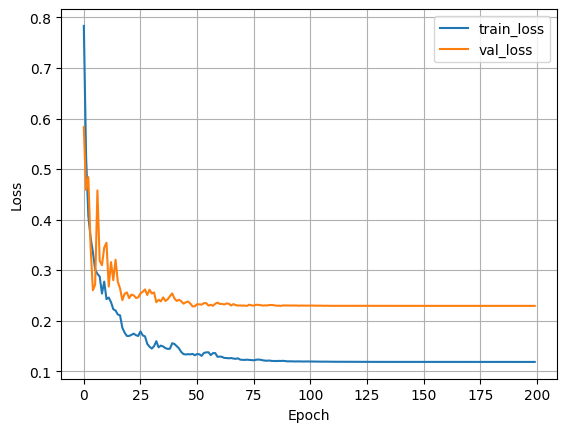

In [31]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [32]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

3/3 [==============================] - 0s 2ms/step
(65, 1)
(65, 1)


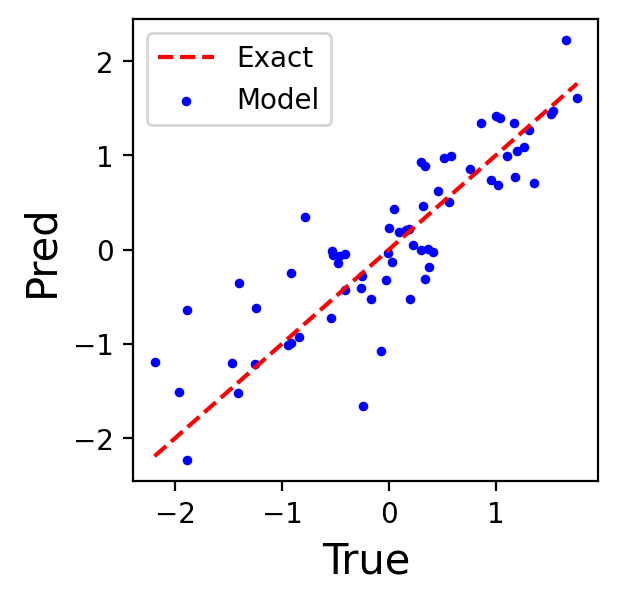

Test MAE: 0.3652357959679354
Test MSE: 0.23367409531983022


In [33]:
# Pred vs True values on test set 

#y_pred = model.predict(x_test)
y_pred = model.predict(x=[x_test[:,0:n_features],x_test[:,n_features:]])
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
test_mse = mean_squared_error(y_true,y_pred)

print("Test MAE: "+str(test_mae))
print("Test MSE: "+str(test_mse))

In [34]:
# save model

#reloaded_model = tf.keras.models.load_model('R_model')
model.save('./Models/R_model_invariant_2body')

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_2body/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_2body/assets


9/9 [==============================] - 0s 941us/step


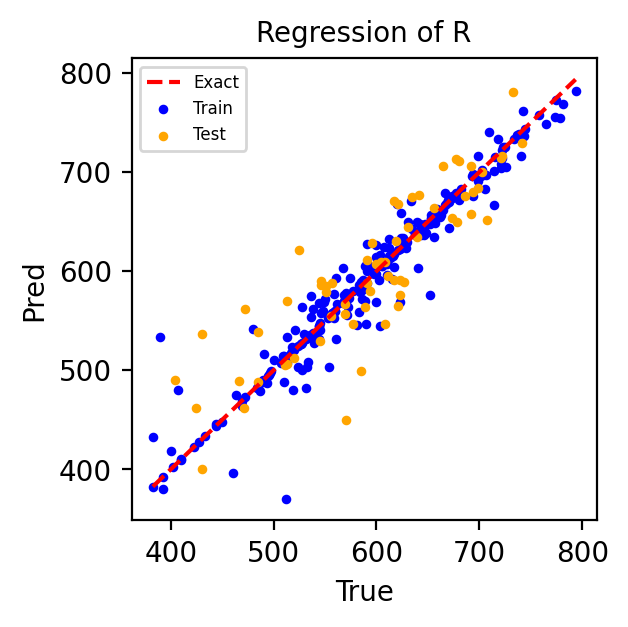

Train MAE (non-normalized): 11.051900183246865
Train RMSE (non-normalized): 21.464997671103827
Train MAPE (non-normalized): 1.9842192768564064
Train R2 (non-normalized): 0.9378913975095038

Test MAE (non-normalized): 31.184560137469944
Test RMSE (non-normalized): 41.27352753393833
Test MAPE (non-normalized): 5.570549025005691
Test R2 (non-normalized): 0.7437672033642488


In [35]:
# Evaluate the model with non-normalized units on the whole dataset

#y_pred_test = model.predict(x_test)
y_pred_test = model.predict(x=[x_test[:,0:n_features],x_test[:,n_features:]])
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

#y_pred_train = model.predict(x_train)
y_pred_train = model.predict(x=[x_train[:,0:n_features],x_train[:,n_features:]])
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("Train MAE (non-normalized): "+str(train_mae))
train_mse = mean_squared_error(y_true_train,y_pred_train,squared=False)
print("Train RMSE (non-normalized): "+str(train_mse))
train_mape = mean_absolute_percentage_error(y_true_train,y_pred_train)*100
print("Train MAPE (non-normalized): "+str(train_mape))
train_r2 = r2_score(y_true_train,y_pred_train)
print("Train R2 (non-normalized): "+str(train_r2))

print()
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("Test MAE (non-normalized): "+str(test_mae))
test_mse = mean_squared_error(y_true_test,y_pred_test,squared=False)
print("Test RMSE (non-normalized): "+str(test_mse))
test_mape = mean_absolute_percentage_error(y_true_test,y_pred_test)*100
print("Test MAPE (non-normalized): "+str(test_mape))
test_r2 = r2_score(y_true_test,y_pred_test)
print("Test R2 (non-normalized): "+str(test_r2))

#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

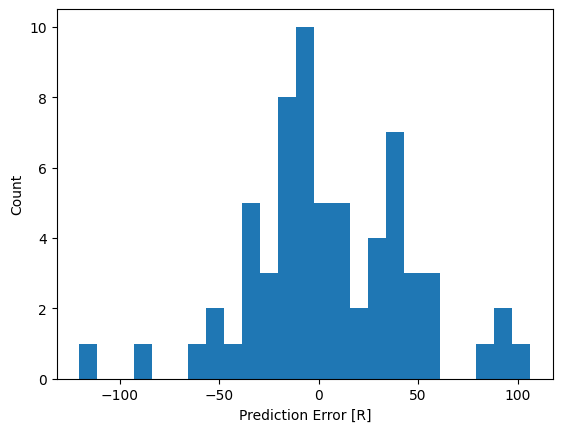

In [36]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


[ 0.  4. 30. 17. 14.]
[        nan 12.32353765 28.14403599 31.54334613 42.65316389]


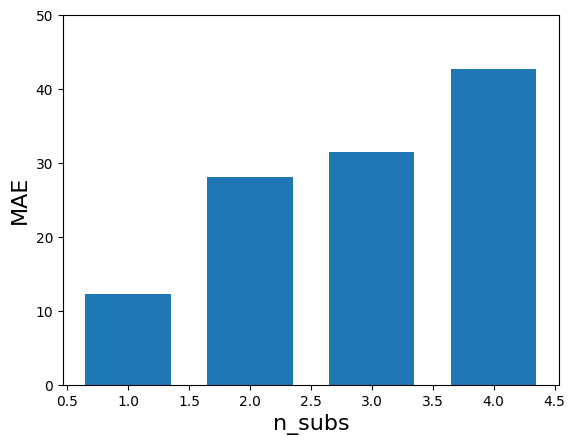

In [38]:
# Error for different nsubs

#x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
#print(x_test[0,:])

# compute number of substitutes for each data test
for i in range(len(nsubs_test)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_test[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_test[i] = nsubs_i
#print(nsubs_test)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim([0,50])
plt.show()

[  1.  28. 109.  63.  58.]
[ 7.44041963  9.25427138 10.21143449 11.78876265 12.76109867]


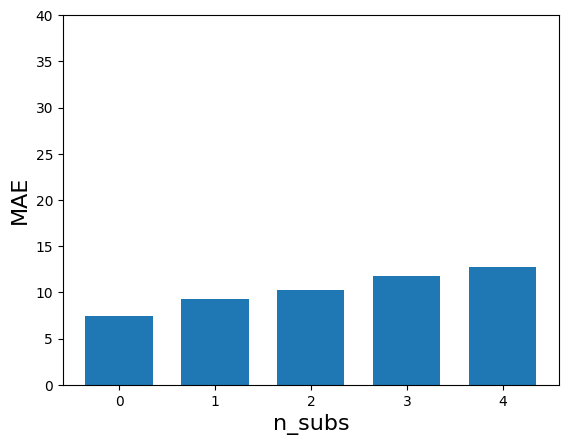

In [40]:
# Error for different nsubs on Training set

nsubs_train = np.zeros( x_train.shape[0] )
#print(x_train[0,:])

# compute number of substitutes for each data train
for i in range(len(nsubs_train)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_train[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_train[i] = nsubs_i
#print(nsubs_train)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_train)):
    error_i = y_pred_train[i] - y_true_train[i]
    if(nsubs_train[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_train[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_train[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_train[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_train[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim([0,40])
plt.show()

In [41]:
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)
    
print()
print('1-BODY')
for i in range(8):
    print(weights[i].flatten()*R_std)

print()
print('2-BODY')
for i in range(9,16):
    print(weights[i].flatten()*R_std)    

1B_0/kernel:0 (5, 1)
1B_1/kernel:0 (5, 1)
1B_2/kernel:0 (5, 1)
1B_3/kernel:0 (5, 1)
1B_4/kernel:0 (5, 1)
1B_5/kernel:0 (5, 1)
1B_6/kernel:0 (5, 1)
1B_7/kernel:0 (5, 1)
2B_0/kernel:0 (25, 1)
2B_1/kernel:0 (25, 1)
2B_2/kernel:0 (25, 1)
2B_3/kernel:0 (25, 1)
2B_4/kernel:0 (25, 1)
2B_5/kernel:0 (25, 1)
2B_6/kernel:0 (25, 1)
2B_7/kernel:0 (25, 1)

1-BODY
[ 29.777721 -83.564804 -99.47675  -43.059956 -43.82736 ]
[-18.919071   -29.968056     0.92775047  26.109442    25.350378  ]
[-10.740868   -4.7224865  -4.506192   20.64139    41.38875  ]
[  6.0873127  -2.128274  -39.94121   -28.556335  -54.681087 ]
[  9.40081  -12.481459 -18.391102 -31.045746 -55.015717]
[ -1.1504153 -13.084343   -8.6698885 -25.61051   -34.818844 ]
[  9.599336 -14.869137 -24.251524 -45.231464 -49.263042]
[  5.9764237  -9.8130455 -18.17466   -30.995779  -38.62684  ]

2-BODY
[ -3.3871434    0.85893375   4.119083    11.005509    24.882425
  -9.973985     7.0553117   17.538828     6.441385    -6.7575827
 -16.356207   -62.09529  

In [42]:
# 2-Body coefficients

a_2b = weights[9:16]
a_2b = np.array(a_2b)
print(a_2b.shape)
a_2b = a_2b[:,:,0]
print(a_2b.shape)


a_matrix = a_2b.reshape((7,5,5))
print(a_matrix.shape)

for i in range(a_matrix.shape[0]):
    print(a_matrix[i,:,:]*R_std)

(7, 25, 1)
(7, 25)
(7, 5, 5)
[[ -3.3871434    0.85893375   4.119083    11.005509    24.882425  ]
 [ -9.973985     7.0553117   17.538828     6.441385    -6.7575827 ]
 [-16.356207   -62.09529    -10.350951    11.330892    -8.87418   ]
 [ -2.8030798    0.94321334 -57.64749      3.1186159  -28.574535  ]
 [  6.2315626    2.8118942  -19.486065    -1.4558352  -32.921104  ]]
[[  -0.7388975  -23.542767     7.661202    -8.73412    -16.911253 ]
 [  -5.931065   -16.243658    -0.7201238   16.67336      8.612198 ]
 [  -4.1222806   -4.289705   -62.10876      4.021155     6.062771 ]
 [  -1.0751041   -7.6254654    2.1100388  -21.577396  -111.65203  ]
 [ -17.635445     4.384173   -29.277454     1.9616022    4.088135 ]]
[[   6.248162    28.336864   -13.547585   -18.61056      1.3086284]
 [   6.8629293  -10.328439   -65.799736     6.661748   -66.86916  ]
 [  -8.1174135   -4.9171352    6.6491365  -18.699802    -0.3057386]
 [  -7.267258     8.236791    -4.4096866 -140.34912     -2.0870333]
 [  -1.9424798 -1

In [52]:
# Invariance test

x1 = dataset_np[132,0:16]
x1_flip = x1.copy()
x1_flip = np.flip(x1)

# one-hot encode of 1-body part
x1_ohe = np.zeros((1,n_features))
x1_flip_ohe = np.zeros((1,n_features))
for j in range(n_pos):
    atom_id = int(x1[j])
    x1_ohe[0,j*n_atom_types+atom_id] = 1.0
    atom_id = int(x1_flip[j])
    x1_flip_ohe[0,j*n_atom_types+atom_id] = 1.0

# one-hot encode of 2-body part
x2_ohe = np.zeros((1,n_features_2body))
x2_flip_ohe = np.zeros((1,n_features_2body))

x_1b = np.split(x_data_1body[i,:],n_pos)
x_flip_1b = np.split(x_data_1body[i,:],n_pos)
x_2b = []
x_flip_2b = []
for j in range(8):
    # direct
    xj = x_1b[j]
    xj_next = x_1b[j+1]
    xj_2b = np.tensordot(xj,xj_next,axes=0)
    xj_2b = xj_2b.flatten()
    x_2b.append(xj_2b)
    # flip
    xj = x_flip_1b[j]
    xj_next = x_flip_1b[j+1]
    xj_2b = np.tensordot(xj,xj_next,axes=0)
    xj_2b = xj_2b.flatten()
    x_flip_2b.append(xj_2b)
for j in reversed(range(8,15)):
    # direct
    xj = x_1b[j]
    xj_next = x_1b[j-1]
    xj_2b = np.tensordot(xj,xj_next,axes=0)
    xj_2b = xj_2b.flatten()
    x_2b.append(xj_2b)
    # flip
    xj = x_flip_1b[j]
    xj_next = x_flip_1b[j-1]
    xj_2b = np.tensordot(xj,xj_next,axes=0)
    xj_2b = xj_2b.flatten()
    x_flip_2b.append(xj_2b)
# direct
x_2b = np.array(x_2b) 
x_2b = x_2b.flatten()
# flip
x_flip_2b = np.array(x_flip_2b) 
x_flip_2b = x_flip_2b.flatten()

x2_ohe[0,:] = x_2b[:]
x2_flip_ohe[0,:] = x_flip_2b[:]

# Predictions
print(x1)

y_pred1 = model.predict(x=[x1_ohe,x2_ohe])
print(y_pred1[0])

y_pred1_flip = model.predict(x=[x1_flip_ohe,x2_flip_ohe])
print(y_pred1_flip[0])

[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 0.]
1/1 [==============================] - 0s 18ms/step
[1.3904243]
1/1 [==============================] - 0s 16ms/step
[1.3904244]


In [ ]:
# function to evaluate 1-body and 2-body terms with the optimal parameters